In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.models import Sequential
from keras.layers.convolutional import ZeroPadding2D
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

## 1- load Images dataset

In [ ]:
def append_ext(fn):
    return str(fn)+".jpg"

#loading dataset labels from csv 
df = pd.read_csv("/content/drive/MyDrive/dataset_2.csv")

# df["img"] = df["img"].apply(append_ext)

df = df.replace(np.nan, 0)

# labels names in csv
classes = ['9-gummy', '16-Incisal Embrasure', '4-color', '41-Central Incisor W/H Ratio','18-black triangle','8-gaps', '52-Crooked']



In [ ]:
#shuffle dataframe before splitting 
df=df.sample(frac=1).reset_index(drop=True)

In [ ]:
# load images in dataframe from saving directory 
# pationing dataset to 80:10:10 , train:valid:test sets
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 2/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/teeth_padded_80/train",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=64,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/teeth_padded_80/valid",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=64,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="/content/drive/MyDrive/teeth_padded_80/test",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 522 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1941 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2343 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 120 validated image filenames.
Found 364 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2099 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# Store the data in X_test, y_test variables by iterating over the batches
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(364, 224, 224, 3) (364, 7)


### Example image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image labels:
['9-gummy', '16-Incisal Embrasure', '4-color', '41-Central Incisor W/H Ratio', '8-gaps']
-0.37061307


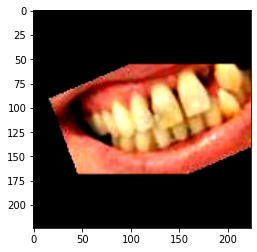

In [ ]:
img =next(training_set)
#print(classes)

l=[]
for i, x in enumerate(classes):
    if img[1][0][i]==1 :
        l.append(x)

print("image labels:")
print(l)

img=img[0][0]  #first image
#print(img.shape)
# print(img)
print(np.amin(img.flatten()))
plt.imshow(img)
training_set.reset()

## 2- Model : VGG-16 with pre-trained weights of face recognition task

In [ ]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False

#model.get_layer("conv2_2").trainable =True
#model.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_2").trainable =True
model.get_layer("conv3_3").trainable =True
model.get_layer("conv4_3").trainable =True
model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_2").trainable =True
model.get_layer("conv5_2").trainable =True
model.get_layer("conv5_1").trainable =True
model.get_layer("conv5_3").trainable =True


#adding output layers
model.add(Flatten())

model.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.075)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add( Dense(32, use_bias=False, kernel_regularizer=keras.regularizers.L2(0.075)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.25))

model.add( Dense(32, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.05)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(7, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
initial_learning_rate = 0.00035
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=4, min_lr=0.00001)

callback=keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=25, verbose=2, mode='auto',
    baseline=None, restore_best_weights=True)

from tensorflow.keras import backend as K
def f1_score(y_true, y_pred):
    '''
    Calculate F1 score
    y_true: true value
    y_pred: predicted value
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return (2 * precision * recall) / (precision + recall + K.epsilon())



#model combile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy',f1_score])

#fit model
history=model.fit(x=training_set, validation_data = valid_set, epochs=75 , shuffle =True, callbacks=[reduce_lr,callback])


Epoch 1/75
31/31 [==============================] - 22s 608ms/step - loss: 12.5084 - binary_accuracy: 0.5395 - f1_score: 0.4969 - val_loss: 12.0303 - val_binary_accuracy: 0.5452 - val_f1_score: 0.5353 - lr: 3.5000e-04
Epoch 2/75
31/31 [==============================] - 18s 586ms/step - loss: 9.9059 - binary_accuracy: 0.5742 - f1_score: 0.5043 - val_loss: 8.8255 - val_binary_accuracy: 0.5286 - val_f1_score: 0.5336 - lr: 3.5000e-04
Epoch 3/75
31/31 [==============================] - 18s 586ms/step - loss: 7.8749 - binary_accuracy: 0.6133 - f1_score: 0.5222 - val_loss: 7.0039 - val_binary_accuracy: 0.7190 - val_f1_score: 0.5026 - lr: 3.5000e-04
Epoch 4/75
31/31 [==============================] - 18s 584ms/step - loss: 6.3383 - binary_accuracy: 0.6405 - f1_score: 0.5351 - val_loss: 5.7016 - val_binary_accuracy: 0.6952 - val_f1_score: 0.5144 - lr: 3.5000e-04
Epoch 5/75
31/31 [==============================] - 18s 586ms/step - loss: 5.1539 - binary_accuracy: 0.6595 - f1_score: 0.5414 - val_l

## Plotting Diagnostic curves

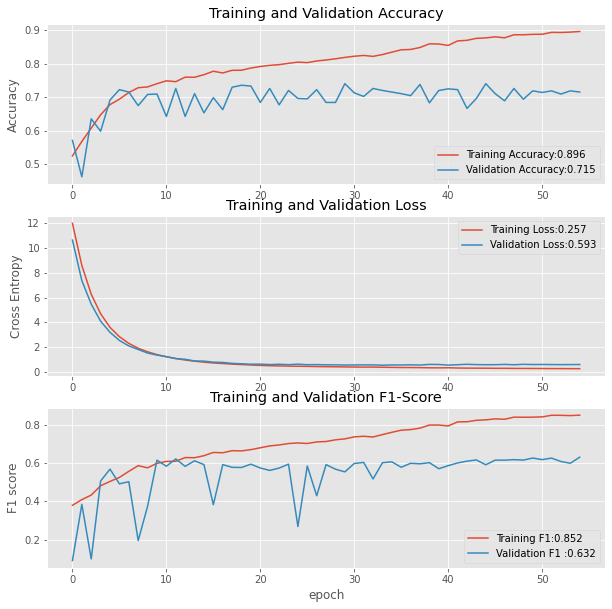

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

F1 = history.history['f1_score']
val_F1 = history.history['val_f1_score']


plt.style.use('ggplot')

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy:{}'.format(str(format(acc[-1],'.3f'))))
plt.plot(val_acc, label='Validation Accuracy:{}'.format(str(format(val_acc[-1],'.3f'))))
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss:{}'.format(str(format(loss[-1],'.3f'))))
plt.plot(val_loss, label='Validation Loss:{}'.format(str(format(val_loss[-1],'.3f'))))
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(F1, label='Training F1:{}'.format(str(format(F1[-1],'.3f'))))
plt.plot(val_F1, label='Validation F1 :{}'.format(str(format(val_F1[-1],'.3f'))))
plt.legend(loc='lower right')
plt.ylabel('F1 score')
plt.title('Training and Validation F1-Score')

plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/model77``.h5')

# **ROC curves**

In [ ]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numbers
import six
import numpy
import matplotlib.collections

predictions= model.predict(test_set)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])




(364, 7)
(2548,)
Best Threshold=0.294500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


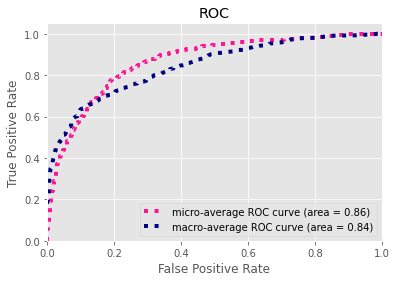

In [ ]:
from numpy import argmax

# Compute micro-average ROC curve and ROC area
print(y_test.shape)
print(y_test.ravel().shape)

fpr["micro"], tpr["micro"], thresholds_micro = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
J = tpr["micro"] - fpr["micro"]
ix = argmax(J)
best_thresh = thresholds_micro[ix]
print('Best Threshold=%f' % (best_thresh))


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(7)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(7): mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 7

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

J = tpr["micro"][2] - fpr["micro"][2]
ix = argmax(J)
best_thresh = thresholds_micro[ix]
#print('Best Threshold=%f' % (best_thresh))


#print(thresholds_micro)
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

plt.legend(loc="lower right")
plt.show()

## **Thresholding at best threshold**

In [ ]:
predictions= model.predict(test_set)

y_pred=[]
for pred in predictions:
    pred[pred>0.55]=1
    pred[pred<=0.55]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
#pd.DataFrame(predictions)

from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.78      0.85      0.82       128
        16-Incisal Embrasure       0.61      0.88      0.72       168
                     4-color       0.88      0.84      0.86       236
41-Central Incisor W/H Ratio       0.59      0.63      0.61       156
           18-black triangle       0.81      0.85      0.83        20
                      8-gaps       0.86      0.82      0.84        60
                  52-Crooked       0.48      0.61      0.54       100

                   micro avg       0.70      0.78      0.74       868
                   macro avg       0.72      0.78      0.74       868
                weighted avg       0.71      0.78      0.74       868
                 samples avg       0.55      0.63      0.56       868



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


true labels : 16-Incisal Embrasure, 4-color, 41-Central Incisor W/H Ratio, 52-Crooked
predicted labels : 16-Incisal Embrasure, 4-color, 41-Central Incisor W/H Ratio


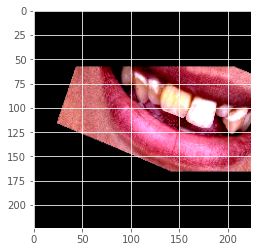

In [ ]:
n=200
# output sample
true_labels=[]
pred_labels = []

for y ,z  in zip(y_test,y_pred):
    true =[]
    pred =[]
    for i, x in enumerate(classes):
        if y[i]==1 :
            true.append(x)
            
        if z[i]==1 :
            pred.append(x)
    true_labels.append(", ".join(true))
    pred_labels.append(", ".join(pred))
        
#print(test_set.index_array)
print("true labels : "+true_labels[n])
print("predicted labels : "+pred_labels[n])

plt.imshow(X_test[n])


#['gummy', 'golden_proportion ', 'gap', 'crowding', 'incisal embrassure ', 'color', 'Central line', 'Crooked', 'Central Incisor W/H Ratio', 'Black triangle', 'perfect']

In [ ]:
# Drawing a roc-auc curve belonging to a specific class
n_class =19
plt.figure()
lw = 2 # line_width

J = tpr[n_class] - fpr[n_class]
ix = argmax(J)

best_thresh = thresholds[ix]
#print('Best Threshold=%f' % (best_thresh))

plt.plot(fpr[n_class], tpr[n_class], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[n_class]) # Drawing Curve according to the class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class:'+classes[n_class])
plt.legend(loc="lower right")
plt.show()

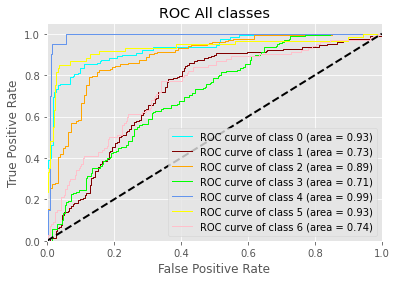

In [ ]:
# Plot all ROC curves

colors = ['aqua', 'maroon','orange', 'lime','cornflowerblue','yellow','pink']

for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC All classes')
plt.legend(loc="lower right")
plt.show()

## Weighted cross entropy loss 

In [ ]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

F1 = history.history['f1_score']
val_F1 = history.history['val_f1_score']


plt.style.use('ggplot')

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy:{}'.format(str(format(acc[-1],'.3f'))))
plt.plot(val_acc, label='Validation Accuracy:{}'.format(str(format(val_acc[-1],'.3f'))))
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss:{}'.format(str(format(loss[-1],'.3f'))))
plt.plot(val_loss, label='Validation Loss:{}'.format(str(format(val_loss[-1],'.3f'))))
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(F1, label='Training F1:{}'.format(str(format(F1[-1],'.3f'))))
plt.plot(val_F1, label='Validation F1 :{}'.format(str(format(val_F1[-1],'.3f'))))
plt.legend(loc='lower right')
plt.ylabel('F1 score')
plt.title('Training and Validation F1-Score')

plt.xlabel('epoch')
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [ ]:
batch_size =1
X_train, y_train = next(training_set)
for i in range(int(len(training_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(training_set)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)

print(X_train.shape, y_train.shape)
training_set.reset()

(1941, 224, 224, 3) (1941, 7)


## Claculating weights in each class and custom loss function

In [ ]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2]) #dim (7,2)
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', classes = [0.,1.],y= y_true[:, i])
    return weights


def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-float(y_true)))*(weights[:,1]**(float(y_true)))*K.binary_crossentropy(float(y_true), y_pred), axis=-1)
    return weighted_loss

class_weights = calculating_class_weights(y_train)
print(class_weights)

[[0.68878637 1.82424812]
 [1.17210145 0.87196765]
 [1.18209501 0.86651786]
 [1.00569948 0.99436475]
 [0.5388673  6.93214286]
 [0.59430496 3.15097403]
 [0.70224313 1.73613596]]


In [ ]:
initial_learning_rate = 0.0025
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75,patience=3, min_lr=0.00001)

from tensorflow.keras import backend as K
def f1_score(y_true, y_pred):
    '''
    Calculate F1 score
    y_true: true value
    y_pred: predicted value
    '''

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return (2 * precision * recall) / (precision + recall + K.epsilon())


class_weights = calculating_class_weights(y_train)
#model combile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss=get_weighted_loss(class_weights),metrics=['binary_accuracy',f1_score])

#fit model
history=model.fit(x=training_set, validation_data = valid_set, epochs=60 , shuffle =True, callbacks=[reduce_lr])


Epoch 1/60
31/31 [==============================] - 23s 649ms/step - loss: 3.2277 - binary_accuracy: 0.5781 - f1_score: 0.4399 - val_loss: 2.6169 - val_binary_accuracy: 0.3964 - val_f1_score: 0.4697 - lr: 0.0025
Epoch 2/60
31/31 [==============================] - 20s 627ms/step - loss: 1.5774 - binary_accuracy: 0.6595 - f1_score: 0.5639 - val_loss: 1.2223 - val_binary_accuracy: 0.5369 - val_f1_score: 0.5359 - lr: 0.0025
Epoch 3/60
31/31 [==============================] - 20s 627ms/step - loss: 0.9167 - binary_accuracy: 0.6887 - f1_score: 0.6073 - val_loss: 0.8624 - val_binary_accuracy: 0.5893 - val_f1_score: 0.5636 - lr: 0.0025
Epoch 4/60
31/31 [==============================] - 20s 625ms/step - loss: 0.6638 - binary_accuracy: 0.7098 - f1_score: 0.6331 - val_loss: 0.7284 - val_binary_accuracy: 0.6512 - val_f1_score: 0.5076 - lr: 0.0025
Epoch 5/60
31/31 [==============================] - 20s 626ms/step - loss: 0.5707 - binary_accuracy: 0.7222 - f1_score: 0.6506 - val_loss: 0.7216 - val_

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate= 2.e-05),loss=get_weighted_loss(class_weights),metrics=['binary_accuracy',f1_score])

#fit model
history=model.fit(x=training_set, validation_data = valid_set, epochs=3 , shuffle =True, callbacks=[reduce_lr])

Epoch 1/3
31/31 [==============================] - 25s 652ms/step - loss: 0.2110 - binary_accuracy: 0.9150 - f1_score: 0.8827 - val_loss: 1.0551 - val_binary_accuracy: 0.7345 - val_f1_score: 0.6143 - lr: 2.0000e-05
Epoch 2/3
31/31 [==============================] - 20s 627ms/step - loss: 0.2176 - binary_accuracy: 0.9121 - f1_score: 0.8792 - val_loss: 1.0624 - val_binary_accuracy: 0.7381 - val_f1_score: 0.6136 - lr: 2.0000e-05
Epoch 3/3
31/31 [==============================] - 20s 627ms/step - loss: 0.2135 - binary_accuracy: 0.9160 - f1_score: 0.8825 - val_loss: 1.0482 - val_binary_accuracy: 0.7345 - val_f1_score: 0.6097 - lr: 2.0000e-05


In [ ]:
model.save('/content/drive/MyDrive/model777````.h5')

In [ ]:
predictions= model.predict(test_set)

y_pred=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
#pd.DataFrame(predictions)

from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.82      0.70      0.75       128
        16-Incisal Embrasure       0.57      0.74      0.65       168
                     4-color       0.81      0.89      0.85       236
41-Central Incisor W/H Ratio       0.56      0.64      0.60       156
           18-black triangle       0.83      0.50      0.62        20
                      8-gaps       0.86      0.70      0.77        60
                  52-Crooked       0.52      0.67      0.59       100

                   micro avg       0.67      0.74      0.71       868
                   macro avg       0.71      0.69      0.69       868
                weighted avg       0.69      0.74      0.71       868
                 samples avg       0.54      0.60      0.53       868



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numbers
import six
import numpy
import matplotlib.collections

predictions= model.predict(test_set)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])




(364, 7)
(2548,)
Best Threshold=0.275354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


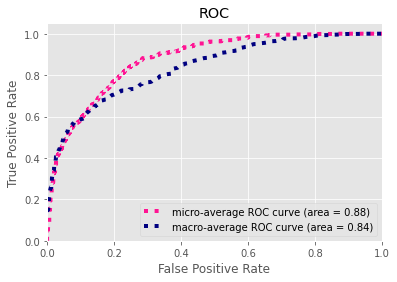

In [ ]:
from numpy import argmax

# Compute micro-average ROC curve and ROC area
print(y_test.shape)
print(y_test.ravel().shape)

fpr["micro"], tpr["micro"], thresholds_micro = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
J = tpr["micro"] - fpr["micro"]
ix = argmax(J)
best_thresh = thresholds_micro[ix]
print('Best Threshold=%f' % (best_thresh))


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(7)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(7): mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 7

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

J = tpr["micro"][2] - fpr["micro"][2]
ix = argmax(J)
best_thresh = thresholds_micro[ix]
#print('Best Threshold=%f' % (best_thresh))


#print(thresholds_micro)
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

plt.legend(loc="lower right")
plt.show()

In [ ]:
predictions= model.predict(test_set)

y_pred=[]
for pred in predictions:
    pred[pred>0.55]=1
    pred[pred<=0.55]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
#pd.DataFrame(predictions)

from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.75      0.73      0.74       128
        16-Incisal Embrasure       0.58      0.72      0.64       168
                     4-color       0.79      0.92      0.85       236
41-Central Incisor W/H Ratio       0.59      0.63      0.61       156
           18-black triangle       0.80      0.40      0.53        20
                      8-gaps       0.84      0.68      0.75        60
                  52-Crooked       0.49      0.70      0.58       100

                   micro avg       0.66      0.75      0.70       868
                   macro avg       0.69      0.68      0.67       868
                weighted avg       0.68      0.75      0.70       868
                 samples avg       0.55      0.60      0.53       868



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


true labels : 16-Incisal Embrasure, 41-Central Incisor W/H Ratio, 18-black triangle
predicted labels : 16-Incisal Embrasure, 4-color, 41-Central Incisor W/H Ratio, 8-gaps, 52-Crooked


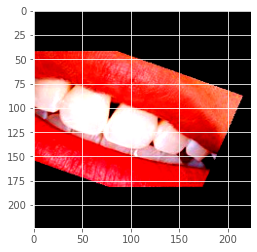

In [ ]:
n=188
# output sample
true_labels=[]
pred_labels = []

for y ,z  in zip(y_test,y_pred):
    true =[]
    pred =[]
    for i, x in enumerate(classes):
        if y[i]==1 :
            true.append(x)
            
        if z[i]==1 :
            pred.append(x)
    true_labels.append(", ".join(true))
    pred_labels.append(", ".join(pred))
        
#print(test_set.index_array)
print("true labels : "+true_labels[n])
print("predicted labels : "+pred_labels[n])

plt.imshow(X_test[n])


#['gummy', 'golden_proportion ', 'gap', 'crowding', 'incisal embrassure ', 'color', 'Central line', 'Crooked', 'Central Incisor W/H Ratio', 'Black triangle', 'perfect']

Best Threshold=0.698054


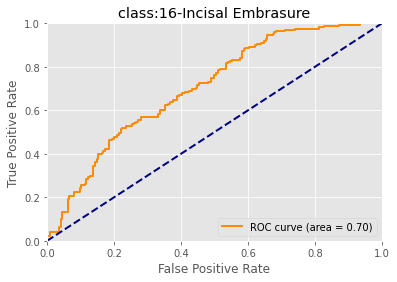

In [ ]:
#Drawing a roc-auc curve belonging to a specific class
n_class =1
plt.figure()
lw = 2 # line_width

J = tpr[n_class] - fpr[n_class]
ix = argmax(J)

best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

plt.plot(fpr[n_class], tpr[n_class], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[n_class]) # Drawing Curve according to the class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('class:'+classes[n_class])
plt.legend(loc="lower right")
plt.show()

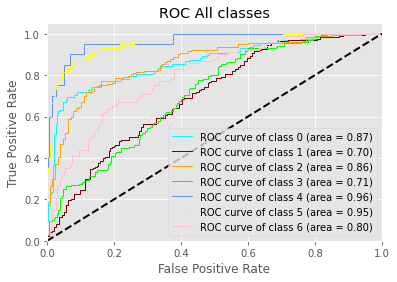

In [ ]:
# Plot all ROC curves

colors = ['aqua', 'maroon','orange', 'lime','cornflowerblue','yellow','pink']

for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC All classes')
plt.legend(loc="lower right")
plt.show()